In [1]:
import numpy as np
import pandas as pd
from import_data import data

## Import the data

In [2]:
data = import_data()

## Separate test set and normalize the data

In [3]:
num_test_samples = 47 # 25% of all samples

np.random.shuffle(data)
test_data = data[:num_test_samples]
data = data[num_test_samples:]

mean = data[:,:-6].mean(axis=0) # leave the target variables out of normalization!
data[:,:-6] -= mean
std = data[:,:-6].std(axis=0)
data[:,:-6] /= std

test_data[:,:-6] -= mean
test_data[:,:-6] /= std

## Define model

In [4]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(32, activation='relu', 
                           input_shape=(train_X.shape[1],)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(6))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

Using TensorFlow backend.


## Set up K-fold cross-validation and train

In [5]:
k = 4
num_val_samples = len(data) // k
num_epochs = 500

validation_scores = []
train_MSE_history = []
val_MSE_history = []
val_MAE_history = []

for fold in range(k):
    
    
    validation_data = data[num_val_samples * fold:
                           num_val_samples *(fold+1)]
    training_data = np.concatenate([data[:num_val_samples * fold],
                                    data[num_val_samples * (fold+1):]], axis=0)
    
    train_X = training_data[:,:-6]
    train_y = training_data[:,-6:]
    val_X = validation_data[:,:-6]
    val_y = validation_data[:,-6:]
    
    #print(train_X.shape, train_y.shape, val_X.shape, val_y.shape)
    print('processing fold #', fold)
    model = build_model()
    train_history = model.fit(train_X, train_y, epochs=num_epochs, 
                              validation_data=(val_X, val_y), 
                              batch_size=1, verbose=0)
    
    train_loss = train_history.history['loss']
    val_loss = train_history.history['val_loss']
    val_mae = train_history.history['val_mean_absolute_error']
    
    train_MSE_history.append(train_loss)
    val_MSE_history.append(val_loss)
    val_MAE_history.append(val_mae)
    validation_score = model.evaluate(val_X, val_y, verbose=0)
    validation_scores.append(validation_score)
    
validation_score = np.average(validation_scores)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


## Average the validation MAE, training and validation MSE over folds for each epoch

In [6]:
avg_train_mse_history = [np.mean([x[i] for x in train_MSE_history]) for i in range(num_epochs)]
avg_val_mse_history = [np.mean([x[i] for x in val_MSE_history]) for i in range(num_epochs)]
avg_val_mae_history = [np.mean([x[i] for x in val_MAE_history]) for i in range(num_epochs)]

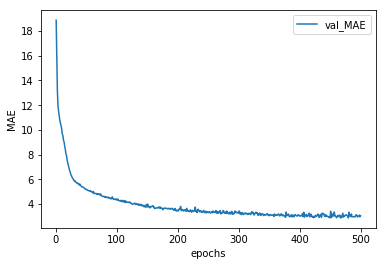

In [7]:
## validation MAE score

import matplotlib.pyplot as plt

plt.plot(range(1, len(avg_val_mae_history) + 1), avg_val_mae_history)

plt.xlabel('epochs')
plt.ylabel('MAE')
plt.legend(['val_MAE'])
plt.show()

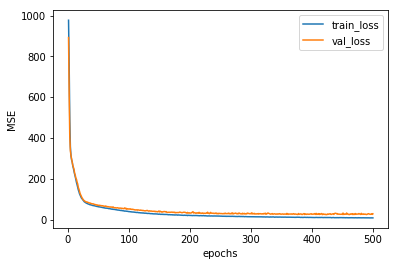

In [8]:
## training and validation MSE score

plt.plot(range(1, len(avg_train_mse_history) + 1), avg_train_mse_history)
plt.plot(range(1, len(avg_val_mse_history) + 1), avg_val_mse_history)

plt.xlabel('epochs')
plt.ylabel('MSE')
plt.legend(['train_loss', 'val_loss'])
plt.show()

## Smooth plot for interpretability

In [9]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smoothed_avg_train_mse_history = smooth_curve(avg_train_mse_history[16:300])
smoothed_avg_val_mse_history = smooth_curve(avg_val_mse_history[16:300])

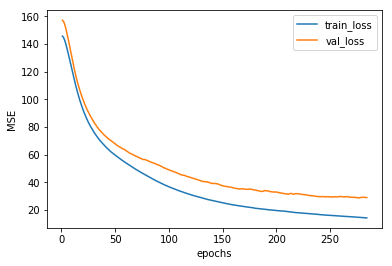

In [10]:
plt.plot(range(1, len(smoothed_avg_train_mse_history) + 1), smoothed_avg_train_mse_history)
plt.plot(range(1, len(smoothed_avg_val_mse_history) + 1), smoothed_avg_val_mse_history)

plt.xlabel('epochs')
plt.ylabel('MSE')
plt.legend(['train_loss', 'val_loss'])
plt.show()

## Build final model and evaluate on test set

In [13]:
model = build_model()
model.fit(data[:,:-6], data[:,-6:], epochs=200, batch_size=1, verbose=0)
test_scores = model.evaluate(test_data[:,:-6], test_data[:,-6:], verbose=0)

In [18]:
print('test MSE: %.2f, test MAE: %.2f' % (test_scores[0], test_scores[1]))

test MSE: 45.23, test MAE: 3.85


In [12]:
## TODO: 
## hyperparameter tuning
## iterated K-fold CV
